### gquant Tutorial Intro

gQuant is a quantitative framework built on top of RAPIDS in the Python language. The computing components of gquant are oriented around its plugins and dataframe workflows. Let's begin by importing `nxpd` (Python package for visualization NetworkX graphs using pydot) and the dataframe workflow component of gQuant.

In [1]:
import sys
sys.path.append('..')

# Import python libs used throughout
import os
import warnings
import nxpd
from gquant.dataframe_flow import TaskGraph

In this tutorial, we are going to use gquant to do a simple quant job. The job tasks are listed below:
    1. load csv stock data
    2. filter out the stocks that has average volume smaller than 50
    3. sort the stock symbols and datetime
    4. add rate of return as a feature into the table
    5. In two branches, compute the mean volume and mean return seperately
    6. read the stock symbol name file and join the computed dataframes
    7. output the result in csv files

Using gquant each task can be thought of as a node that operates on cudf dataframes. We formulate a task list or workflow by using these nodes. Below we write the schema for the tasks above.

In [2]:
# load csv stock data
task_csvdata = {
    'id': 'node_csvdata',
    'type': 'CsvStockLoader',
    'conf': {
        'path': './data/stock_price_hist.csv.gz'
    },
    'inputs': []
}

# filter out the stocks that has average volume smaller than 50
task_minVolume = {
    'id': 'node_minVolume',
    'type': 'VolumeFilterNode',
    'conf': {
        'min': 50.0
    },
    'inputs': ['node_csvdata']
}

# sort the stock symbols and datetime
task_sort = {
    'id': 'node_sort',
    'type': 'SortNode',
    'conf': {
        'keys': ['asset', 'datetime']
    },
    'inputs': ['node_minVolume']
}

# add rate of return as a feature into the table
task_addReturn = {
    'id': 'node_addReturn',
    'type': 'ReturnFeatureNode',
    'conf': {},
    'inputs': ['node_sort']
}

# read the stock symbol name file and join the computed dataframes
task_stockSymbol = {
    'id': 'node_stockSymbol',
    'type': 'StockNameLoader',
    'conf': {
        'path': './data/security_master.csv.gz'
    },
    'inputs': []
}

# In two branches, compute the mean volume and mean return seperately
task_volumeMean = {
    'id': 'node_volumeMean',
    'type': 'AverageNode',
    'conf': {
        'column': 'volume'
    },
    'inputs': ['node_addReturn']
}

task_returnMean = {
    'id': 'node_returnMean',
    'type': 'AverageNode',
    'conf': {
        'column': 'returns'
    },
    'inputs': ['node_addReturn']
}

task_leftMerge1 = {
    'id': 'node_leftMerge1',
    'type': 'LeftMergeNode',
    'conf': {
        'column': 'asset'
    },
    'inputs': ['node_volumeMean', 'node_stockSymbol']
}

task_leftMerge2 = {
    'id': 'node_leftMerge2',
    'type': 'LeftMergeNode',
    'conf': {
        'column': 'asset'
    },
    'inputs': ['node_returnMean', 'node_stockSymbol']
}

# output the result in csv files

task_outputCsv1 = {
    'id': 'node_outputCsv1',
    'type': 'OutCsvNode',
    'conf': {
        'path': 'symbol_volume.csv'
    },
    'inputs': ['node_leftMerge1']
}

task_outputCsv2 = {
    'id': 'node_outputCsv2',
    'type': 'OutCsvNode',
    'conf': {
        'path': 'symbol_returns.csv'
    },
    'inputs': ['node_leftMerge2']
}

A task schema defined in python is a dictionary with the following fields: `id`, `type`, `conf`, `inputs`, and `filepath`. Additionally there is a `load` and a `save` field used for running workflows (described later on). The `id` for a given task must be unique within a workflow. Tasks use the `id` field in their `inputs` field for specifying that the output(s) of other tasks are inputs. The `type` is the class of the compute task or plugin. The gquant framework already implements a number of such plugins. These can be found in `gquant.plugin_nodes`. For example:

In [3]:
import inspect
from gquant.plugin_nodes.transform import VolumeFilterNode

print(inspect.getsource(VolumeFilterNode))

class VolumeFilterNode(Node):

    def columns_setup(self):
        self.required = {"asset": "int64",
                         "volume": "float64"}
        self.addition = {"mean_volume": "float64"}

    def process(self, inputs):
        """
        filter the dataframe based on the min and max values of the average
        volume for each fo the assets.

        Arguments
        -------
         inputs: list
            list of input dataframes.
        Returns
        -------
        dataframe
        """

        input_df = inputs[0]
        volume_df = input_df[['volume', "asset"]].groupby(
                ["asset"]).mean().reset_index()
        volume_df.columns = ["asset", 'mean_volume']
        merged = input_df.merge(volume_df, on="asset", how='left')
        if 'min' in self.conf:
            minVolume = self.conf['min']
            merged = merged.query('mean_volume >= %f' % (minVolume))
        if 'max' in self.conf:
            maxVolume = self.conf['max']
            me

The `conf` field is the configuration field. It is used to parameterize a task. The `conf` can be used to access user set parameters within a plugin (such as `self.conf['min']` in example above). The `filepath` is used to specify a python module where a custom plugin is defined. In another tutorial we go over how to create custom plugins. A custom node schema could look something like:
```
custom_task = {
    'id': 'node_custom_calc',
    'type': 'CustomNode',
    'conf': {},
    'inputs': ['some_other_node'],
    'filepath': 'custom_nodes.py'
}
```
Below we define our complete workflow and visualize it as a graph.

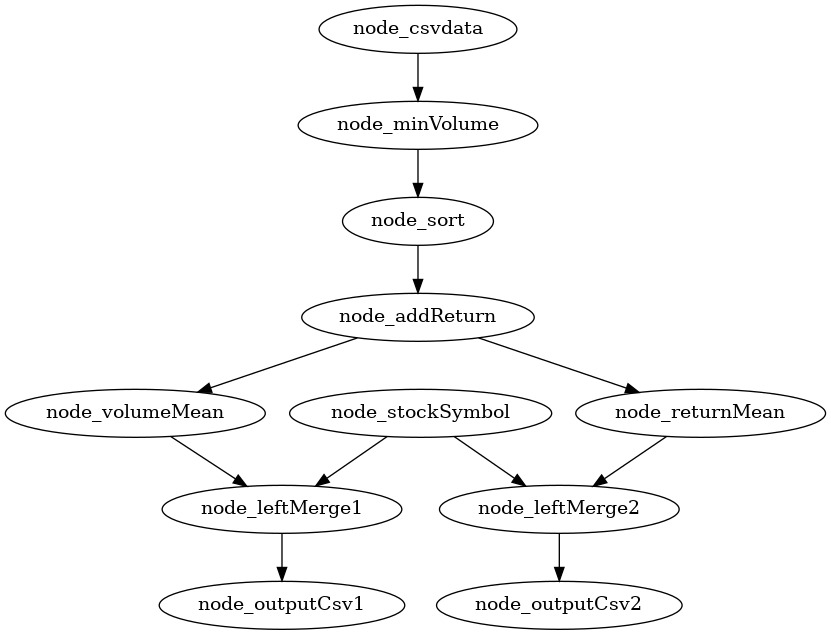

In [4]:
task_list = [
    task_csvdata, task_minVolume, task_sort, task_addReturn,
    task_stockSymbol, task_volumeMean, task_returnMean,
    task_leftMerge1, task_leftMerge2,
    task_outputCsv1, task_outputCsv2]

task_graph = TaskGraph(task_list)
nxpd.draw(task_graph.viz_graph(), show='ipynb')

The workflow can now be saved to a yaml file for future re-use.

In [5]:
from tempfile import NamedTemporaryFile

wflow_file = NamedTemporaryFile(prefix='wflow_', suffix='.yaml', delete=False)
wflow_file.close()
task_graph.save_taskgraph(wflow_file.name)

print('Workflow File: {}'.format(wflow_file.name))

Workflow File: /tmp/wflow_85p9xori.yaml


Here is a snippet of the contents in the resulting yaml file:

In [6]:
N = 29
with open(wflow_file.name) as myfile:
    head = [next(myfile) for x in range(N)]

print(''.join(head))

- id: node_csvdata
  type: CsvStockLoader
  conf:
    path: ./data/stock_price_hist.csv.gz
  inputs: []
- id: node_minVolume
  type: VolumeFilterNode
  conf:
    min: 50.0
  inputs:
  - node_csvdata
- id: node_sort
  type: SortNode
  conf:
    keys:
    - asset
    - datetime
  inputs:
  - node_minVolume
- id: node_addReturn
  type: ReturnFeatureNode
  conf: {}
  inputs:
  - node_sort
- id: node_stockSymbol
  type: StockNameLoader
  conf:
    path: ./data/security_master.csv.gz
  inputs: []



The yaml file describes the computation tasks. We can load it and visualize it as a graph. Note, that since the individual tasks can be parameterized, the overall workflow can be parameterized as well. In this manner the workflow can be reused dynamically. 

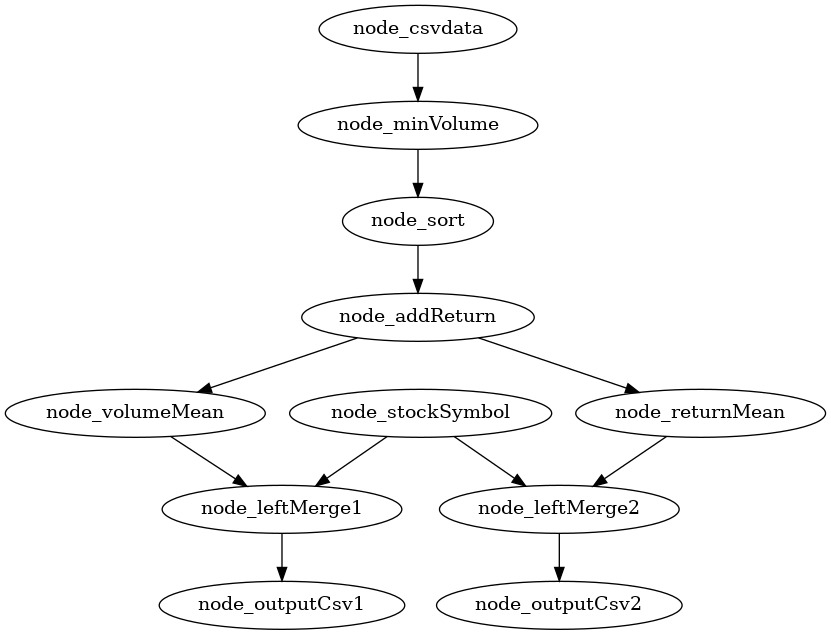

In [7]:
task_graph = TaskGraph.load_taskgraph(wflow_file.name)
nxpd.draw(task_graph.viz_graph(), show='ipynb')

### Building and running a workflow

The next step would be to run the workflow. Optionally, we can build the workflow prior to running. This could be useful to inspect the column names and types, validate that the plugins can be instantiated, and check for errors. This can be done by calling `build_workflow` function to traverses the workflow graph without running the dataframe computations. In the example below we inspect the column names and types for the inputs and outputs of the `node_leftMerge` task.

In [8]:
from pprint import pprint

task_graph.build()
print('Output of build workflow are instances of each task in a dictionary:')
print(str(task_graph))

lmerge1_task_instance = task_graph['node_leftMerge1']

print('\n\nInput columns in incoming dataframes:')
pprint(lmerge1_task_instance.input_columns)

print('\n\nOutput columns in outgoing dataframe:')
pprint(lmerge1_task_instance.output_columns)

print('\n\n')

Output of build workflow are instances of each task in a dictionary:
node_csvdata: <gquant.plugin_nodes.dataloader.csvStockLoader.CsvStockLoader object at 0x7f7578f85470>
node_minVolume: <gquant.plugin_nodes.transform.volumeFilterNode.VolumeFilterNode object at 0x7f7578f854e0>
node_sort: <gquant.plugin_nodes.transform.sortNode.SortNode object at 0x7f7578f85550>
node_addReturn: <gquant.plugin_nodes.transform.returnFeatureNode.ReturnFeatureNode object at 0x7f7578f855c0>
node_stockSymbol: <gquant.plugin_nodes.dataloader.stockNameLoader.StockNameLoader object at 0x7f7578f85630>
node_volumeMean: <gquant.plugin_nodes.transform.averageNode.AverageNode object at 0x7f7578f856a0>
node_returnMean: <gquant.plugin_nodes.transform.averageNode.AverageNode object at 0x7f7578f85710>
node_leftMerge1: <gquant.plugin_nodes.transform.leftMergeNode.LeftMergeNode object at 0x7f7578f85780>
node_leftMerge2: <gquant.plugin_nodes.transform.leftMergeNode.LeftMergeNode object at 0x7f7578f857f0>
node_outputCsv1: <g

Building the workflow is optional, because the `build_workflow` function is called within `run`, but it is useful for inspection. We use the `run` function to run the dataframe computations. The required `run` function arguments are a task list and outputs list. The `run` also takes an optional `replace` argument which is used and explained later on.

In [9]:
outlist = ['node_csvdata', 'node_outputCsv1', 'node_outputCsv2']

# o = dff.run(task_list, outputs=outlist, replace=replace_spec)
# csv1_df, csv2_df = dff.run(task_list, outputs=outlist)
with warnings.catch_warnings():
    warnings.simplefilter('ignore', category=UserWarning)
    csvdata_df, csv1_df, csv2_df = task_graph.run(outputs=outlist)

In [10]:
print('Outputs Csv1 Dataframe:\n{}'.format(csv1_df))
print('\nOutputs Csv2 Dataframe:\n{}'.format(csv2_df))

print('\nCsv Files produced:\n')
!find . -iname "*symbol*"

Outputs Csv1 Dataframe:
     asset              volume  asset_name
0  869584   673.6252347192934         LPT
1  869589  110.45606585788555        DSLV
2  869590   66.60725338491301        BPTH
3  869592   56.04176626826024          SP
4  869349    91.1619912790698        VIIX
5  869357   307.7649913344889        USLV
6  869358   487.5099673202609         UVE
7  869363   149.0384482758621        SNOW
8  869368   130.8917431192658        AMBR
9  869369  149.52366548042698         IBP
[3674 more rows]

Outputs Csv2 Dataframe:
     asset                  returns  asset_name
0  869584   0.00036941850449688024         LPT
1  869589     0.001077215924445625        DSLV
2  869590     0.005320585829942715        BPTH
3  869592     0.000501874835926174          SP
4  869349     0.004717268101121209        VIIX
5  869357    0.0057297397856464856        USLV
6  869358    0.0013285777584282467         UVE
7  869363  -2.8580346399647218e-05        SNOW
8  869368   -0.0015823243387458213        AMBR


Above, we can see that two resulting csv files were generated:
- symbol_returns.csv
- symbol_volume.csv

The nice thing about using a workflow task graph is that we can evaluate a sub-graph. For example, if are interested in the `node_volumeMean` result only, we can run the workflow tasks only relevant for that computation. Additionally, if we do not want to re-run tasks we can use the `replace` argument of the `run` function with a `load` option. The `replace` argument needs to be a dictionary where each key is the task/node id. The values are a replacement task-spec dictionary i.e. where each key is a spec overload and value is what to overload with. In the example below instead of re-running `node_csvdata` that loads `csv` into a `cudf` dataframe, we use its dataframe output above to load from.

In [11]:
replace_spec = {
    'node_csvdata': {
        'load': csvdata_df,
        'save': True
    }
}

with warnings.catch_warnings():
    warnings.simplefilter('ignore', category=UserWarning)
    (volmean_df,) = task_graph.run(
        outputs=['node_volumeMean'],
        replace=replace_spec)

print(volmean_df.head())

   asset              volume
0    631   350.2600259993499
1    914   266.2237735849054
2   1404   2073.529167746952
3   1544   80.65922330097106
4   1545  18922.826861182257


As a convenience we can save the check points for any of the nodes in the graph on disk and re-load. This is done by specifying boolean `True` for the save option. In the example above the `replace_spec` directs `run` to save on disk for the `node_csvdata`. If `load` was boolean then the data would be loaded from disk presuming the data was saved to disk in a prior run. The default directory for saving is `<current_workdir>/.cache/<node_id>.hdf5`. PyTables is required for the saving to disk functionality. Install via:
```
conda install -c anaconda pytables
```

The replace spec is also used for overriding parameters in the tasks. For example, in the task `node_minVolume` if instead of `50.0` we wanted to use `40.0` our replace spec would be:
```
replace_spec = {
    'node_minVolume': {
        'conf': {
            'min': 40.0
        }
    },
    'some_task': etc...
}
```

If we want to evalute a particular task multiple times it does not make sense to re-run everything from the very beginning. For example, we can save the `node_returnMean` result on disk.

In [12]:
replace_spec = {
    'node_csvdata': {
        'load': True
    },
    'node_returnMean': {
        'save': True
    }
}

with warnings.catch_warnings():
    warnings.simplefilter('ignore', category=UserWarning)
    (returnmean_df,) = task_graph.run(outputs=['node_returnMean'], replace=replace_spec)

print('Return Mean Dataframe:\n{}'.format(returnmean_df))

Return Mean Dataframe:
    asset                 returns
0    631   2.579372358333652e-05
1    914  -0.0008932574948235621
2   1404   0.0004232514430167556
3   1544   0.0011525606145957475
4   1545    0.000783956968693138
5   1551   0.0010664550162285777
6   1556  0.00040300307029187137
7   1562   0.0013682239808026346
8   1565   0.0015257181852492234
9   1568    0.002258228200891726
[3674 more rows]


Then we can load the `returnmean_df` from the saved file and evaluate only tasks that we are interested in.

In [13]:
warnings.simplefilter('ignore', category=UserWarning)

print('Using in-memory dataframes for load:')
replace_spec = {
    'node_csvdata': {
        'load': csvdata_df
    },
    'node_returnMean': {
        'load': returnmean_df
    }
}

%time out_tuple = task_graph.run(outputs=['node_outputCsv2'], replace=replace_spec)

print('\nUsing cached dataframes on disk for load:')
replace_spec = {
    'node_csvdata': {
        'load': True
    },
    'node_returnMean': {
        'load': True
    }
}

%time out_tuple = task_graph.run(outputs=['node_outputCsv2'], replace=replace_spec)

print('\nRe-running dataframes calculations instead of using load:')
replace_spec = {
    'node_csvdata': {
        'load': True
    }
}

%time out_tuple = task_graph.run(outputs=['node_outputCsv2'], replace=replace_spec)

Using in-memory dataframes for load:
CPU times: user 48 ms, sys: 4 ms, total: 52 ms
Wall time: 53.6 ms

Using cached dataframes on disk for load:
CPU times: user 48 ms, sys: 0 ns, total: 48 ms
Wall time: 47.1 ms

Re-running dataframes calculations instead of using load:
CPU times: user 1.3 s, sys: 1.33 s, total: 2.64 s
Wall time: 2.64 s


Above we are comparing the various load approaches: in-memory, from disk, and not loading at all. When working interactively, or in situations requiring iterative and explorative workflows, we save significant amount of time by just re-loading data we do not need to recalculate.

An idiomatic way to save data, if not on disk, or load data, if present on disk, is demonstrated below.

In [14]:
loadsave_csvdata = \
    'load' if os.path.isfile('./.cache/node_csvdata.hdf5') else 'save'
loadsave_returnmean = \
    'load' if os.path.isfile('./.cache/node_returnMean.hdf5') else 'save'

replace_spec = {
    'node_csvdata': {
        loadsave_csvdata: True
    },
    'node_returnMean': {
        loadsave_returnmean: True
    }
}

%time out_tuple = task_graph.run(outputs=['node_outputCsv2'], replace=replace_spec)


CPU times: user 56 ms, sys: 4 ms, total: 60 ms
Wall time: 57.2 ms


In [15]:
# Clean up

# Remove temporary workflow file.
os.unlink(wflow_file.name)